![](https://hsto.org/getpro/habr/post_images/68f/fc1/d69/68ffc1d69c10d1ede103288c779c8f4e.jpg) 

# Наша первая нейросеть в Keras 

Изначально Keras создавалася как удобная надстройка над Theano. Отсюда появилось такое греческой название пакета (переводится как "рог"), ставшее отсылкой к Одиссее Гомера. Сегодня Keras поддерживает второй знаменитый фрэймворк Tensorflow, созданный Google и использует его в качестве базового. 

## 1. О задаче, которую мы будем решать

Для своего первого знакомства с нейросетками, мы будем использовать встроенный датасет под названием `boston_housing`. Как это не удивительно, речь пойдёт о недвижимости и ценах на неё. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [3]:
from keras.datasets import boston_housing
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

Using TensorFlow backend.


In [4]:
y_train.shape

(404,)

In [5]:
X_test.shape

(102, 13)

Проскалируем переменные.

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scl = StandardScaler()
X_train = scl.fit_transform(X_train)#сохраняем мат и дисп для скал тестовой выборки
X_test = scl.transform(X_test)

## 2. Регрессия - моя профессия 

Оцените уже давно и до боли нам знакомую линейную регрессию. Посмотрите на качество модели. Прикрутите к ней $l_2$-регуляризатор, подберите оптимальное значение для гиерпараметра с помощью `greadsearch`. Посмотрите на качество модели. В качестве метрики используйте $MSE$. 

In [7]:
def expand(X):
    return np.c_[X,np.ones((X.shape[0],1))]

def mse(x,y,w):
    y_hat=np.dot(x,w)
    return np.sum((y - y_hat)**2)/x.shape[0]
#найдем оценки ols параметров в явном виде по известной формуле:
ols_param=np.linalg.inv(expand(X_train).T.dot(expand(X_train))).dot(expand(X_train).T).dot(y_train)

print('ошибка с мнк оценкой для train = {}'.format(round(mse(expand(X_train),y_train,ols_param),3)))
print('ошибка с мнк оценкой для test = {}'.format(round(mse(expand(X_test),y_test,ols_param),3)))

ошибка с мнк оценкой для train = 22.005
ошибка с мнк оценкой для test = 23.196


### Здесь не все так однозначно!
   Из [статьи](https://habr.com/ru/company/ods/blog/322076/) взята формула для ols оценки с регуляризацией. Вроде там логично в конце выводится то, что добавление к функции ошибки L2 нормы приводит к добавлению единичной матр, умноженной на лямбду, к  XTX. Перебор lambda показывает, что ошибка только увеличививается для train (что логично,ведь рег помогает бороться с переобучением на train), но имеет тенденцию убывать до некоторого значения для test.
  

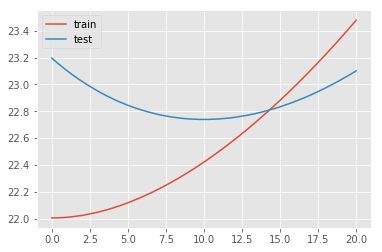

In [8]:
r_train=np.zeros((100,2))
r_test=np.zeros((100,2))
for n,lambd in enumerate(np.linspace(0,20,100)):
    olsl2_param=np.linalg.inv(expand(X_train).T.dot(expand(X_train))+lambd*np.diag(np.ones(expand(X_train).shape[1]),0)).dot(expand(X_train).T).dot(y_train)
    #train
    r_train[n]=lambd,round(mse(expand(X_train),y_train,olsl2_param),3)
    #test
    r_test[n]=lambd,round(mse(expand(X_test),y_test,olsl2_param),3)

fig, ax = plt.subplots()
plt.plot(r_train.T[0],r_train.T[1], label='train')
plt.plot(r_test.T[0],r_test.T[1], label='test') 
leg = ax.legend()

In [9]:
n_lambda=np.where(r_test.T[1]==r_test.T[1].min())
lambd=r_test.T[0][n_lambda[0][0]]
olsl2_param_b=np.linalg.inv(expand(X_train).T.dot(expand(X_train))+lambd*np.diag(np.ones(expand(X_train).shape[1]),0)).dot(expand(X_train).T).dot(y_train)
print('best lambda = {}'.format(lambd))
print('mse for train with L2 = {}'.format(round(mse(expand(X_train),y_train,olsl2_param_b),3)))
print('mse for test with L2 = {}'.format(round(mse(expand(X_test),y_test,olsl2_param_b),3)))

best lambda = 9.696969696969697
mse for train with L2 = 22.398
mse for test with L2 = 22.739


## 3. Нейросеть - регрессия

Как это не удивительно, линейная регрессия это частный, самый простой случай нейросети. Постройте в keras нейросеть из одного нейрона. Обучите её. Посмотрите на качество, сравните с обычной регрессией. 

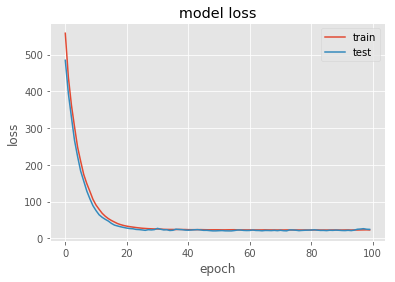

mse for train = 22.688610926713093
mse for test = 24.28236022650027


In [10]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam

model=Sequential()
model.add(Dense(1, input_dim=X_train.shape[1],activation='linear'))
#В качестве оптимайзера возьмем обычный SGD
sgd = SGD(lr=0.01, momentum=0, nesterov=False)
model.compile(loss='mean_squared_error', optimizer=sgd)
history=model.fit(X_train, y_train, epochs=100, batch_size=100, validation_data=(X_test, y_test), verbose = 0)

fig=plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

print('mse for train = {}'.format(history.history['loss'][-1]))
print('mse for test = {}'.format(history.history['val_loss'][-1]))

Прикрутите к сетке [регуляризатор.](https://keras.io/regularizers/) Посмотрите на качество модели.

Прикрутили L2 для слоя, ошибка на train ожидаемо увеличилась, на test снизилась.

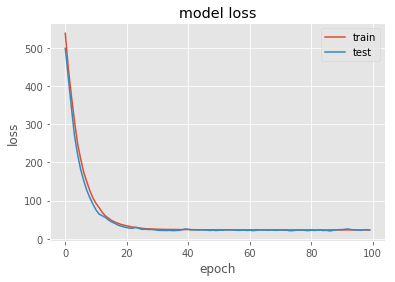

mse for train with l2 = 22.955150273766847
mse for test with l2 = 22.687682731478823


In [11]:
model=Sequential()
model.add(Dense(1, input_dim=X_train.shape[1],activation='linear',
                kernel_regularizer=regularizers.l2(0.01)))
sgd = SGD(lr=0.01, momentum=0, nesterov=False)



model.compile(loss='mean_squared_error', optimizer=sgd)
history=model.fit(X_train, y_train, epochs=100, batch_size=100, validation_data=(X_test, y_test), verbose = 0)

fig=plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

print('mse for train with l2 = {}'.format(history.history['loss'][-1]))
print('mse for test with l2 = {}'.format(history.history['val_loss'][-1]))

## 4. Один слой и оптимальное число нейронов 

**Итак, небольшое задание для самостоятельной работы.**

Постройте нейронную сеть с одним скрытым слоем. Постройте для неё картинку с зависимостью качества модели от числа используемых в сети нейронов на обучении и тесте. По оси $x$ отложите число нейронов, используемое в слое. По оси $y$ качество модели. Для борьбы с переобучением используйте early stopping. Число нейронов перебирайте от $1$ до $20$. Запаситесь терпением и не забудьте проинтерпретировать картинки.

### Мой коммент
Вероятно, из-за того, что данных не оч много, большое кол-во нейронов приводит к переобучению сети (о чем свидетельствует практически всегда на много меньшая ошибка на train (красная линия) по сравнению с test (синяя).Обратная ситуация для двух случаев, когда ошибка на тесте оказывается ниже, а на train оч высокая,  скорее всего связана, с изначальной инициализацией параметров и работой градиентного спуска (мы просто попадали в какие-то локальные минимумы). Перезапуск кода, выдаст уже другой результат, где этого может не быть. 

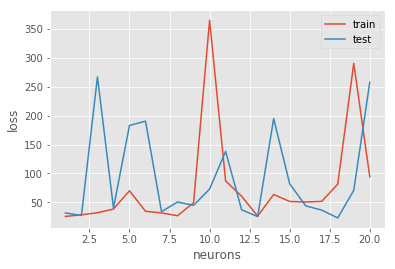

In [12]:
from IPython import display
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience = 2)

mse_train=np.zeros(20)
mse_test=np.zeros(20)
for neur in range(1,21):
    model=Sequential()
    model.add(Dense(neur, input_dim=X_train.shape[1],activation='linear',
                    kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(1, input_dim=neur,activation='linear',
                    kernel_regularizer=regularizers.l2(0.01)))
    sgd = SGD(lr=0.01, momentum=0, nesterov=False)
    model.compile(loss='mean_squared_error', optimizer=sgd)
    history=model.fit(X_train, y_train, epochs=100, batch_size=100, validation_data=(X_test, y_test),
                      callbacks = [early_stopping_monitor],verbose =0)
   
    mse_train[neur-1]=history.history['loss'][-1]
    mse_test[neur-1]=history.history['val_loss'][-1]
    
    fig=plt.figure()
    plt.plot(range(1,21),mse_train)
    plt.plot(range(1,21),mse_test)
    plt.ylabel('loss')
    plt.xlabel('neurons')
    plt.legend(['train', 'test'], loc='best')
    display.clear_output(wait=True)
    plt.show()


## 5. Больше слоёв

Попробуйте построит двух и трёх-слойные сетки с разным числом нейронов. Попробуйте добиться максимально возможного качества. Обратите внимание, что данных у нас очень мало, нейронка будем маленькой и быстро оцениваимой. Это позволяет делать перебор гиперпараметров. Когда данных очень много, перебор - довольно сложная штука. 

### Мой коммент
Большее кол-во слоев, как и нейронов приводит к быстрому переочению и нестабильным результатам (не спасает регуляризация, дропаут, he_normal и более продвинутые алгоритмы градиентного спуска). Если смотреть на MSE, то лучший результат у меня получился по сути с лин рег и регуляризацией, то есть одним нейроном, и momentum sgd с параметром 0.1. Минамальная ошибка для test 21.51.

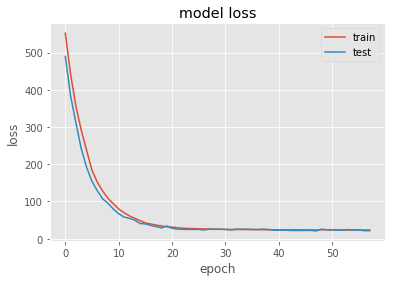

mse for train with l2 = 23.427071561907777
mse for test with l2 = 21.51979528688917


In [102]:
early_stopping_monitor = EarlyStopping(patience = 5)

model=Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], kernel_initializer='he_normal',
                 kernel_regularizer=regularizers.l2(0.01)))
# model.add(BatchNormalization())
# model.add(LeakyReLU())
# model.add(Dropout(0.5))

# model.add(Dense(1, input_dim=13,activation='linear',kernel_initializer='he_normal',
#                 kernel_regularizer=regularizers.l2(0.01)))
# opt = Nadam(lr=0.1)    
opt = SGD(lr=0.01, momentum=0.1, nesterov=False)
model.compile(loss='mean_squared_error', optimizer=opt)
history=model.fit(X_train, y_train, epochs=100, batch_size=100, validation_data=(X_test, y_test),
                  callbacks = [early_stopping_monitor],verbose = 0)

fig=plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

print('mse for train with l2 = {}'.format(history.history['loss'][-1]))
print('mse for test with l2 = {}'.format(history.history['val_loss'][-1]))